# Dynamic Size DataLoader for a Dynamic Size Model - Time Series Classification

In [ ]:
from fastai.vision.all import *
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

/home/hoa/miniconda3/envs/blog/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hoa/miniconda3/envs/blog/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


What is a Dynamic Size Model -> A Model can work with different size inputs. For example: Image with different resolution or a time series sequence with different length.

What is the technique behinds? Below is examples of using `AdaptiveAvgPool` and `RNN` for a classification model 

### AdaptiveAvgPool

The output is fixed no matter the size of the input

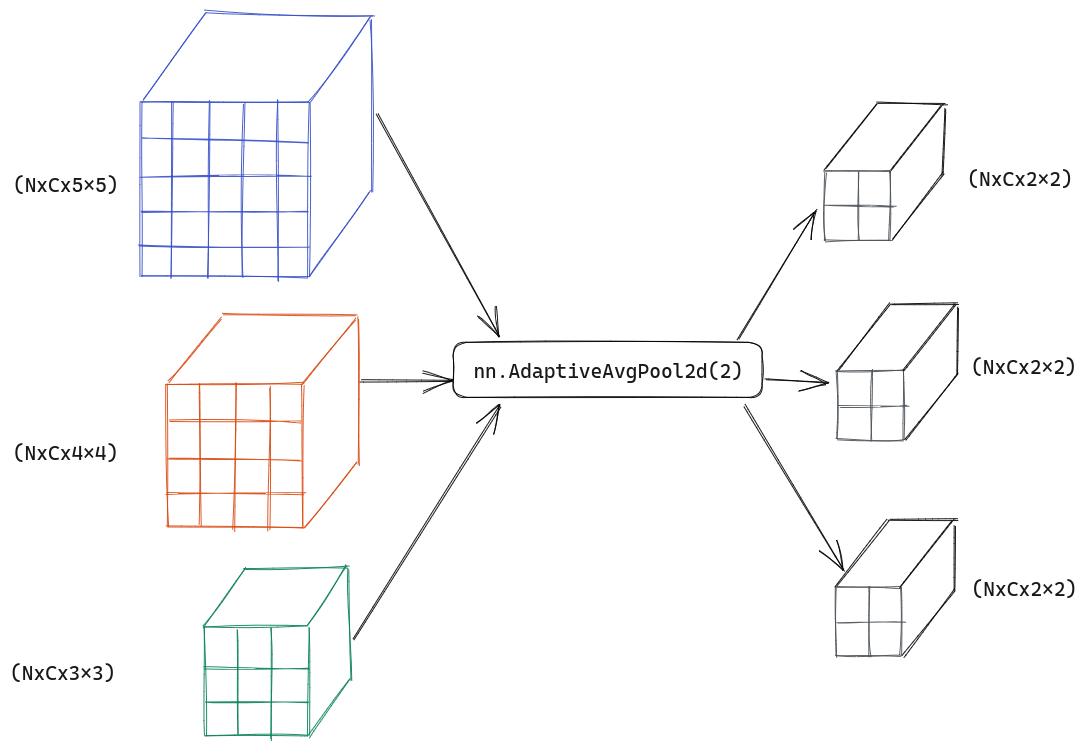

In [ ]:
x1 = torch.randn(8,16,5,5)
x2 = torch.randn(8,16,6,4)
x2 = torch.randn(8,16,4,3)

In [ ]:
nn.AdaptiveAvgPool2d(2)(x1).shape, nn.AdaptiveAvgPool2d(2)(x2).shape

(torch.Size([8, 16, 2, 2]), torch.Size([8, 16, 2, 2]))

### RNN

In a sequence classification problem, one popular technique is using a `RNN` model, extracting the last timestep feature and finally passing by a linear layer. So this kind of architecture doesn't depend on the input either.

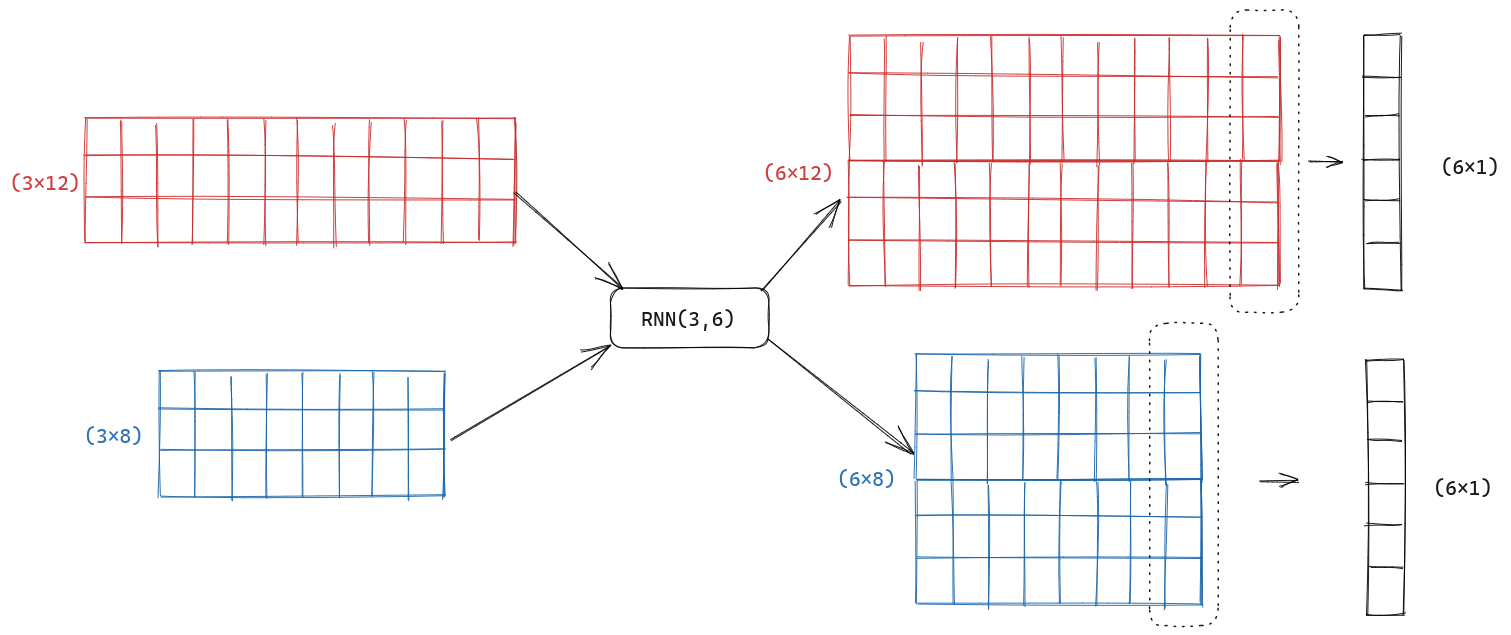

In [ ]:
x1 = torch.randn(16, 512, 3)
x2 = torch.randn(16, 224, 3)

In [ ]:
rnn = nn.RNN(3,100)

In [ ]:
rnn(x1)[0].shape

torch.Size([16, 512, 100])

In [ ]:
rnn(x1)[0][:,-1].shape, rnn(x2)[0][:,-1].shape

(torch.Size([16, 100]), torch.Size([16, 100]))

There are many available to used models like that in various libraries. For example: [timeseriesai](https://timeseriesai.github.io/tsai/). So the difficulty might not stay in building model but how to prepare the data to make use of full power of these models. Each problem is different so usually you have to write the `DataLoader` yourself

Reference: Code and idea taken from @Ivan answer of the question [pytorch-can-i-group-batches-by-length](https://stackoverflow.com/questions/68782144/pytorch-can-i-group-batches-by-length) on stackoverflow

## Dynamic DataLoader

Let's firstly create a dataset where each item is a 1d serie with different length

In [ ]:
class DS(Dataset):
    def __init__(self, signals):
        super().__init__()
        self.len = len(signals)
        self.signals = signals

    def __getitem__(self, i):
        return self.signals[i]

    def __len__(self):
        return self.len

In [ ]:
signal_len = np.random.randint(0, 100, (16*6))
signals = [np.random.rand(s) for s in signal_len]
ds = DS(signals)

In [ ]:
signal_len

array([52, 22, 67, 94, 96, 74,  6, 75, 95, 55, 31, 94, 70, 57, 61, 48, 85,
        3, 59, 31, 45, 66, 21, 92, 26, 84, 44, 55, 41, 31, 67, 81, 58, 78,
       59, 84, 30, 16, 77,  2, 90, 90, 35, 90, 90, 21, 12, 49, 17,  4, 67,
       10,  5, 29, 13, 73, 78, 57, 40,  4, 91, 40, 42, 62, 99, 62,  1, 74,
       58,  4, 17, 30, 23, 32,  1, 75, 12, 39, 64, 59, 30, 89, 72, 77,  6,
       57, 91, 51, 72, 30, 72, 47, 13, 45, 41, 75])

### Collate Function

Even when you have a model that can handle input with different size, every item in a batch must have the same shape so they can be stacked together ( size of item in a batch are equals, size of different batchs are different ). The `collate_fn` parameters in pytorch [DataLoader](https://pytorch.org/docs/stable/data.html) is responsible for this job

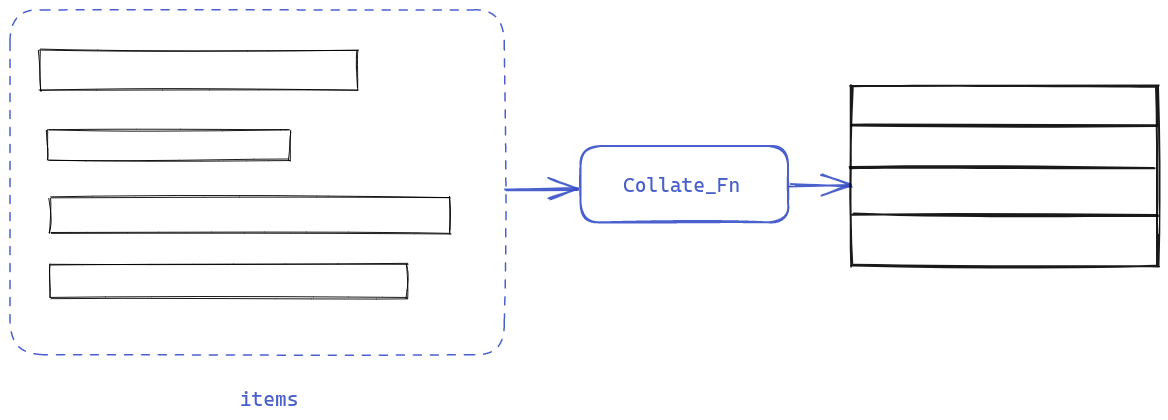

Note: Before writting any time consuming code, you should try out a simple technique to reshape a timeserie: [F.interpolate](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html). This will down/up samples the input to a given size. This way you won't have a dynamic size DataLoader but because it's very simple to build, you can use it as your baseline result 

In [ ]:
x = torch.sin(torch.arange(0,5,0.01))

[<matplotlib.lines.Line2D>]

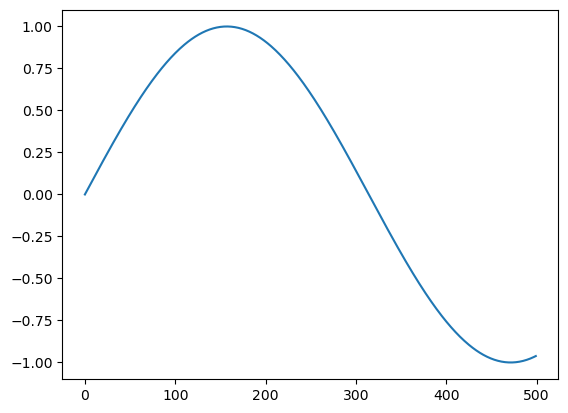

In [ ]:
plt.plot(x)

[<matplotlib.lines.Line2D>]

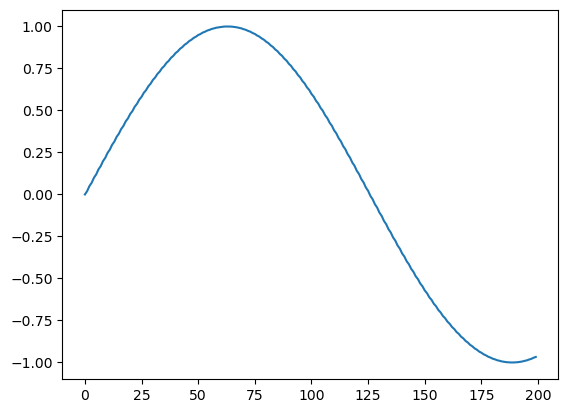

In [ ]:
plt.plot(np.array(F.interpolate(x[None,None,:], 200)[0].squeeze()))

[<matplotlib.lines.Line2D>]

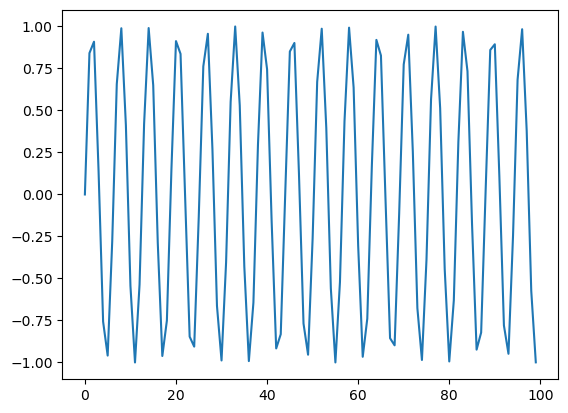

In [ ]:
plt.plot(x)

(torch.Size([16, 100]), torch.Size([16, 100]))

In [ ]:
from tsai.all import *

/home/hoa/miniconda3/envs/blog/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
model = RNN(10,2)

In [ ]:
x = torch.randn(4,10,200)

In [ ]:
x = x.transpose(2,1)

In [ ]:
x1 = model.rnn(x)

In [ ]:
x1[0].shape

torch.Size([4, 200, 100])

In [ ]:
output = x1[0]

In [ ]:
output[:,-1].shape

torch.Size([4, 100])

from ts